In [2]:
#write scores into test sets
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from minicons import scorer
import os
import torch

# Set CUDA device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Set working directory
os.chdir('/home/qy2672/backup')

def safe_score_sequence(text, lm, tokenizer):
    try:
        # Get the device from the model
        device = next(lm.model.parameters()).device
        
        # Tokenize and move to correct device in one step
        inputs = tokenizer(
            text,
            return_tensors='pt',
            truncation=True,
            max_length=256,
            padding=True
        ).to(device)  # Move the whole input dict to device
        
        return lm.sequence_score(inputs)[0]
    except Exception as e:
        print(f"Error processing text: {text}")
        print(f"Error: {str(e)}")
        return float('nan')
    
# models = ['babylm-default', 'babylm-balanced', 'loose-default', 'loose-balanced', 'removed']
# dos = pd.read_csv('data/datives/test/alternant_of_dos.csv')
# pos = pd.read_csv('data/datives/test/alternant_of_pos.csv')
models = ['removed'] 
dos = pd.read_csv('experiments/do_datives.csv')
pos = pd.read_csv('experiments/po_datives.csv')

for model_name in models:
    model_path = 'qing-yao/'+model_name+'_seed-42_1e-3'

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Load model with explicit device placement
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float32,
        device_map="auto"
    )

    # Initialize scorer
    lm = scorer.IncrementalLMScorer(
        model=model,
        device="auto",
        tokenizer=tokenizer
    )
    dos['do' + model_name] = dos['sentence'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    dos['po' + model_name] = dos['alternant'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    dos[model_name + '_ratio'] = dos['do'+model_name] - dos['po'+model_name]
    dos.drop(columns=['do'+model_name, 'po'+model_name], inplace=True)
    dos.to_csv('experiments/do_datives.csv', index = False)
    pos['do' + model_name] = pos['sentence'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    pos['po' + model_name] = pos['alternant'].apply(lambda x: safe_score_sequence(x, lm, tokenizer))
    pos[model_name + '_ratio'] = pos['do'+model_name] - pos['po'+model_name]
    pos.drop(columns=['do'+model_name, 'po'+model_name], inplace=True)
    pos.to_csv('experiments/po_datives.csv', index = False)




Model: babylm-default
Optimal shift: 0.2129
DO accuracy: 0.8563
PO accuracy: 0.8562
Accuracy difference: 0.0001

Model: babylm-balanced
Optimal shift: 0.2399
DO accuracy: 0.7314
PO accuracy: 0.7313
Accuracy difference: 0.0000

Model: loose-default
Optimal shift: 0.1876
DO accuracy: 0.8535
PO accuracy: 0.8536
Accuracy difference: 0.0001

Model: loose-balanced
Optimal shift: 0.2361
DO accuracy: 0.7290
PO accuracy: 0.7290
Accuracy difference: 0.0000

Model: babylm-default
------------------
Type 'alternating' (n=4760): 0.8613
Type 'po_only' (n=1466): 0.8677
Type 'benefactive_alternating' (n=582): 0.7921
Type 'benefactive_po_only' (n=78): 0.8077

Model: babylm-balanced
------------------
Type 'alternating' (n=4760): 0.7242
Type 'po_only' (n=1466): 0.7415
Type 'benefactive_alternating' (n=582): 0.7577
Type 'benefactive_po_only' (n=78): 0.7821

Model: loose-default
------------------
Type 'alternating' (n=4760): 0.8515
Type 'po_only' (n=1466): 0.8677
Type 'benefactive_alternating' (n=582): 

/tmp/ipykernel_177966/3290801425.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x='Sample Type', y='Score', palette={'DO': do_color, 'PO': po_color}, ax=ax_violin)
/tmp/ipykernel_177966/3290801425.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x='Sample Type', y='Score', palette={'DO': do_color, 'PO': po_color}, ax=ax_violin)
/tmp/ipykernel_177966/3290801425.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x='Sample Type', y='Score', palette={'DO': do_color, 'PO': po_color}, ax=ax_

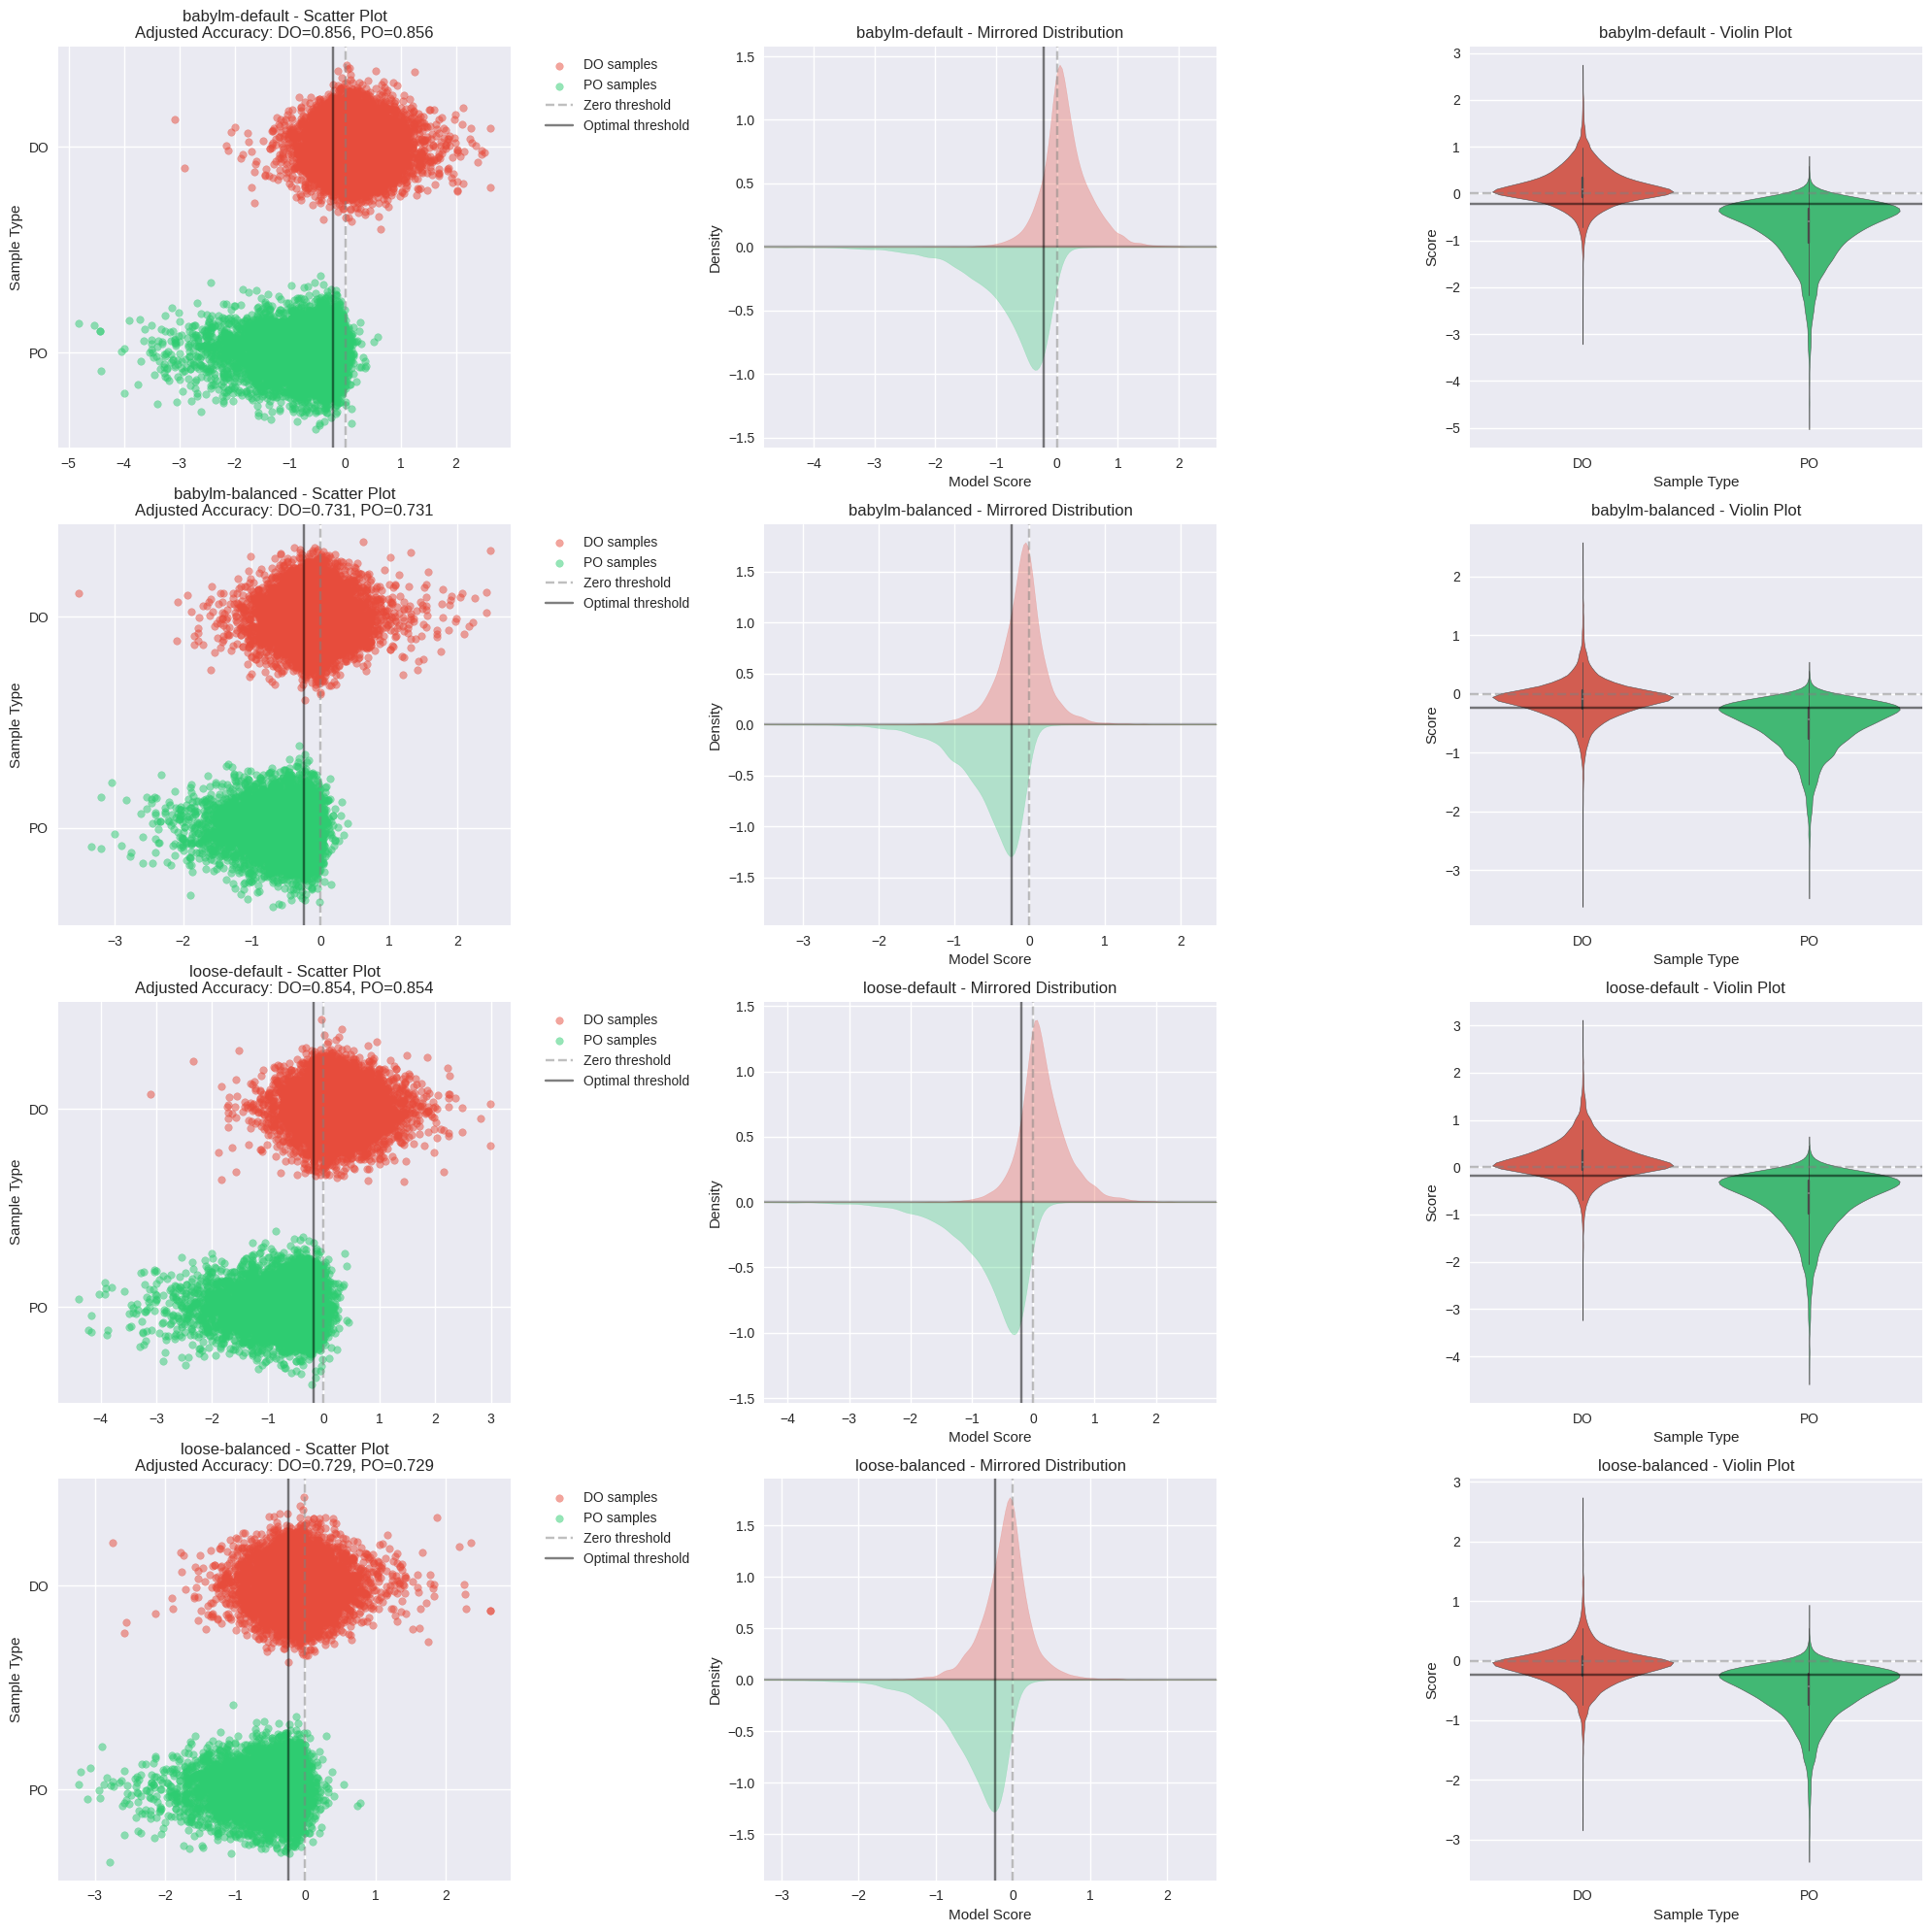

In [14]:
#compute optimal shifts and plot
import pandas as pd
import os 

os.chdir('/home/qy2672/backup')
pos = pd.read_csv('data/datives/test/alternant_of_pos.csv')
dos = pd.read_csv('data/datives/test/alternant_of_dos.csv')

models = ['babylm-default', 'babylm-balanced', 'loose-default', 'loose-balanced']

import numpy as np

def calculate_accuracies(scores, shift, target_class):
    """Calculate accuracy for a given shift. target_class indicates if these are DO samples (1) or PO samples (0)"""
    predictions = (scores + shift) > 0  # Predict DO if score > 0
    accuracy = np.mean(predictions == target_class)
    return accuracy

def find_balancing_shift(dos_scores, pos_scores, tolerance=0.0001, max_iterations=100):
    """Find shift that balances DO and PO prediction accuracies using binary search"""
    left = -1
    right = 1
    best_shift = 0
    min_diff = float('inf')
    
    for _ in range(max_iterations):
        shift = (left + right) / 2
        dos_acc = calculate_accuracies(dos_scores, shift, target_class=1)
        pos_acc = calculate_accuracies(pos_scores, shift, target_class=0)
        diff = abs(dos_acc - pos_acc)
        
        if diff < min_diff:
            min_diff = diff
            best_shift = shift
            
        if diff < tolerance:
            break
            
        if dos_acc < pos_acc:
            left = shift
        else:
            right = shift
            
    return best_shift, min_diff

# Process each model
results = {}
for model_name in models:
    # Get scores from your existing dataframes
    dos_scores = dos[model_name + '_ratio']
    pos_scores = pos[model_name + '_ratio']
    
    # Find optimal shift
    shift, diff = find_balancing_shift(dos_scores, pos_scores)
    
    # Calculate final accuracies with the found shift
    final_dos_acc = calculate_accuracies(dos_scores, shift, target_class=1)
    final_pos_acc = calculate_accuracies(pos_scores, shift, target_class=0)
    
    results[model_name] = {
        'shift': shift,
        'dos_accuracy': final_dos_acc,
        'pos_accuracy': final_pos_acc,
        'accuracy_difference': diff
    }

# Print results
for model_name, result in results.items():
    print(f"\nModel: {model_name}")
    print(f"Optimal shift: {result['shift']:.4f}")
    print(f"DO accuracy: {result['dos_accuracy']:.4f}")
    print(f"PO accuracy: {result['pos_accuracy']:.4f}")
    print(f"Accuracy difference: {result['accuracy_difference']:.4f}")

# Get unique types
unique_types = pos['verb_type'].unique()

# For each model and type combination
for model_name in models:
    shift = results[model_name]['shift']
    print(f"\nModel: {model_name}")
    print("------------------")
    
    # For each type
    for type_value in unique_types:
        # Get subset of data for this type
        type_subset = pos[pos['verb_type'] == type_value]
        
        # Get scores for this subset
        subset_scores = type_subset[model_name + '_ratio']
        
        # Calculate accuracy (these are PO examples, so target_class=0)
        accuracy = calculate_accuracies(subset_scores, shift, target_class=0)
        
        # Print results with sample size
        n_samples = len(type_subset)
        print(f"Type '{type_value}' (n={n_samples}): {accuracy:.4f}")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

fig, axes = plt.subplots(4, 3, figsize=(20, 20))  # Updated layout for violin plots
plt.style.use('seaborn-v0_8')

# Color scheme
po_color = '#2ecc71'  # green
do_color = '#e74c3c'  # red

for idx, model_name in enumerate(models):
    ax_scatter = axes[idx, 0]
    ax_combined = axes[idx, 1]
    ax_violin = axes[idx, 2]  

    do_scores = dos[model_name + '_ratio']
    po_scores = pos[model_name + '_ratio']
    shift = results[model_name]['shift']

    # 1. Scatter plot with jitter
    do_y = np.random.normal(0.6, 0.02, size=len(do_scores))  
    po_y = np.random.normal(0.4, 0.02, size=len(po_scores))
    ax_scatter.scatter(do_scores, do_y, alpha=0.5, c=do_color, label='DO samples', s=30)
    ax_scatter.scatter(po_scores, po_y, alpha=0.5, c=po_color, label='PO samples', s=30)
    ax_scatter.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='Zero threshold')
    ax_scatter.axvline(x=-shift, color='black', linestyle='-', alpha=0.5, label='Optimal threshold')
    ax_scatter.set_title(f'{model_name} - Scatter Plot\nAdjusted Accuracy: DO={results[model_name]["dos_accuracy"]:.3f}, PO={results[model_name]["pos_accuracy"]:.3f}')
    ax_scatter.set_ylabel('Sample Type')
    ax_scatter.set_yticks([0.4, 0.6])
    ax_scatter.set_yticklabels(['PO', 'DO'])
    ax_scatter.legend(bbox_to_anchor=(1.05, 1))

    # 2. Mirrored density plots (second column)
    kde_do = stats.gaussian_kde(do_scores)
    kde_po = stats.gaussian_kde(po_scores)
    x_range = np.linspace(min(np.min(do_scores), np.min(po_scores)),
                          max(np.max(do_scores), np.max(po_scores)), 200)
    do_density = kde_do(x_range)
    po_density = kde_po(x_range)

    ax_combined.fill_between(x_range, do_density, np.zeros_like(x_range), alpha=0.3, color=do_color, label='DO samples')
    ax_combined.fill_between(x_range, -po_density, np.zeros_like(x_range), alpha=0.3, color=po_color, label='PO samples')
    ax_combined.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='Zero threshold')
    ax_combined.axvline(x=-shift, color='black', linestyle='-', alpha=0.5, label='Optimal threshold')
    ax_combined.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax_combined.set_title(f'{model_name} - Mirrored Distribution')
    ax_combined.set_xlabel('Model Score')
    ax_combined.set_ylabel('Density')
    ax_combined.set_xlim(x_range[0], x_range[-1])

    max_density = max(np.max(do_density), np.max(po_density))
    ax_combined.set_ylim(-max_density * 1.1, max_density * 1.1)

    # 3. Violin plot (third column)
    data = {
        'Score': np.concatenate([do_scores, po_scores]),
        'Sample Type': ['DO'] * len(do_scores) + ['PO'] * len(po_scores)
    }
    sns.violinplot(data=data, x='Sample Type', y='Score', palette={'DO': do_color, 'PO': po_color}, ax=ax_violin)
    ax_violin.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Zero threshold')
    ax_violin.axhline(y=-shift, color='black', linestyle='-', alpha=0.5, label='Optimal threshold')
    ax_violin.set_title(f'{model_name} - Violin Plot')

plt.tight_layout()
plt.show()

/tmp/ipykernel_239419/473168593.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x='Sample Type', y='Score', palette={'DO': do_color, 'PO': po_color}, ax=ax_violin)
/tmp/ipykernel_239419/473168593.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x='Sample Type', y='Score', palette={'DO': do_color, 'PO': po_color}, ax=ax_violin)
/tmp/ipykernel_239419/473168593.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x='Sample Type', y='Score', palette={'DO': do_color, 'PO': po_color}, ax=ax_violin

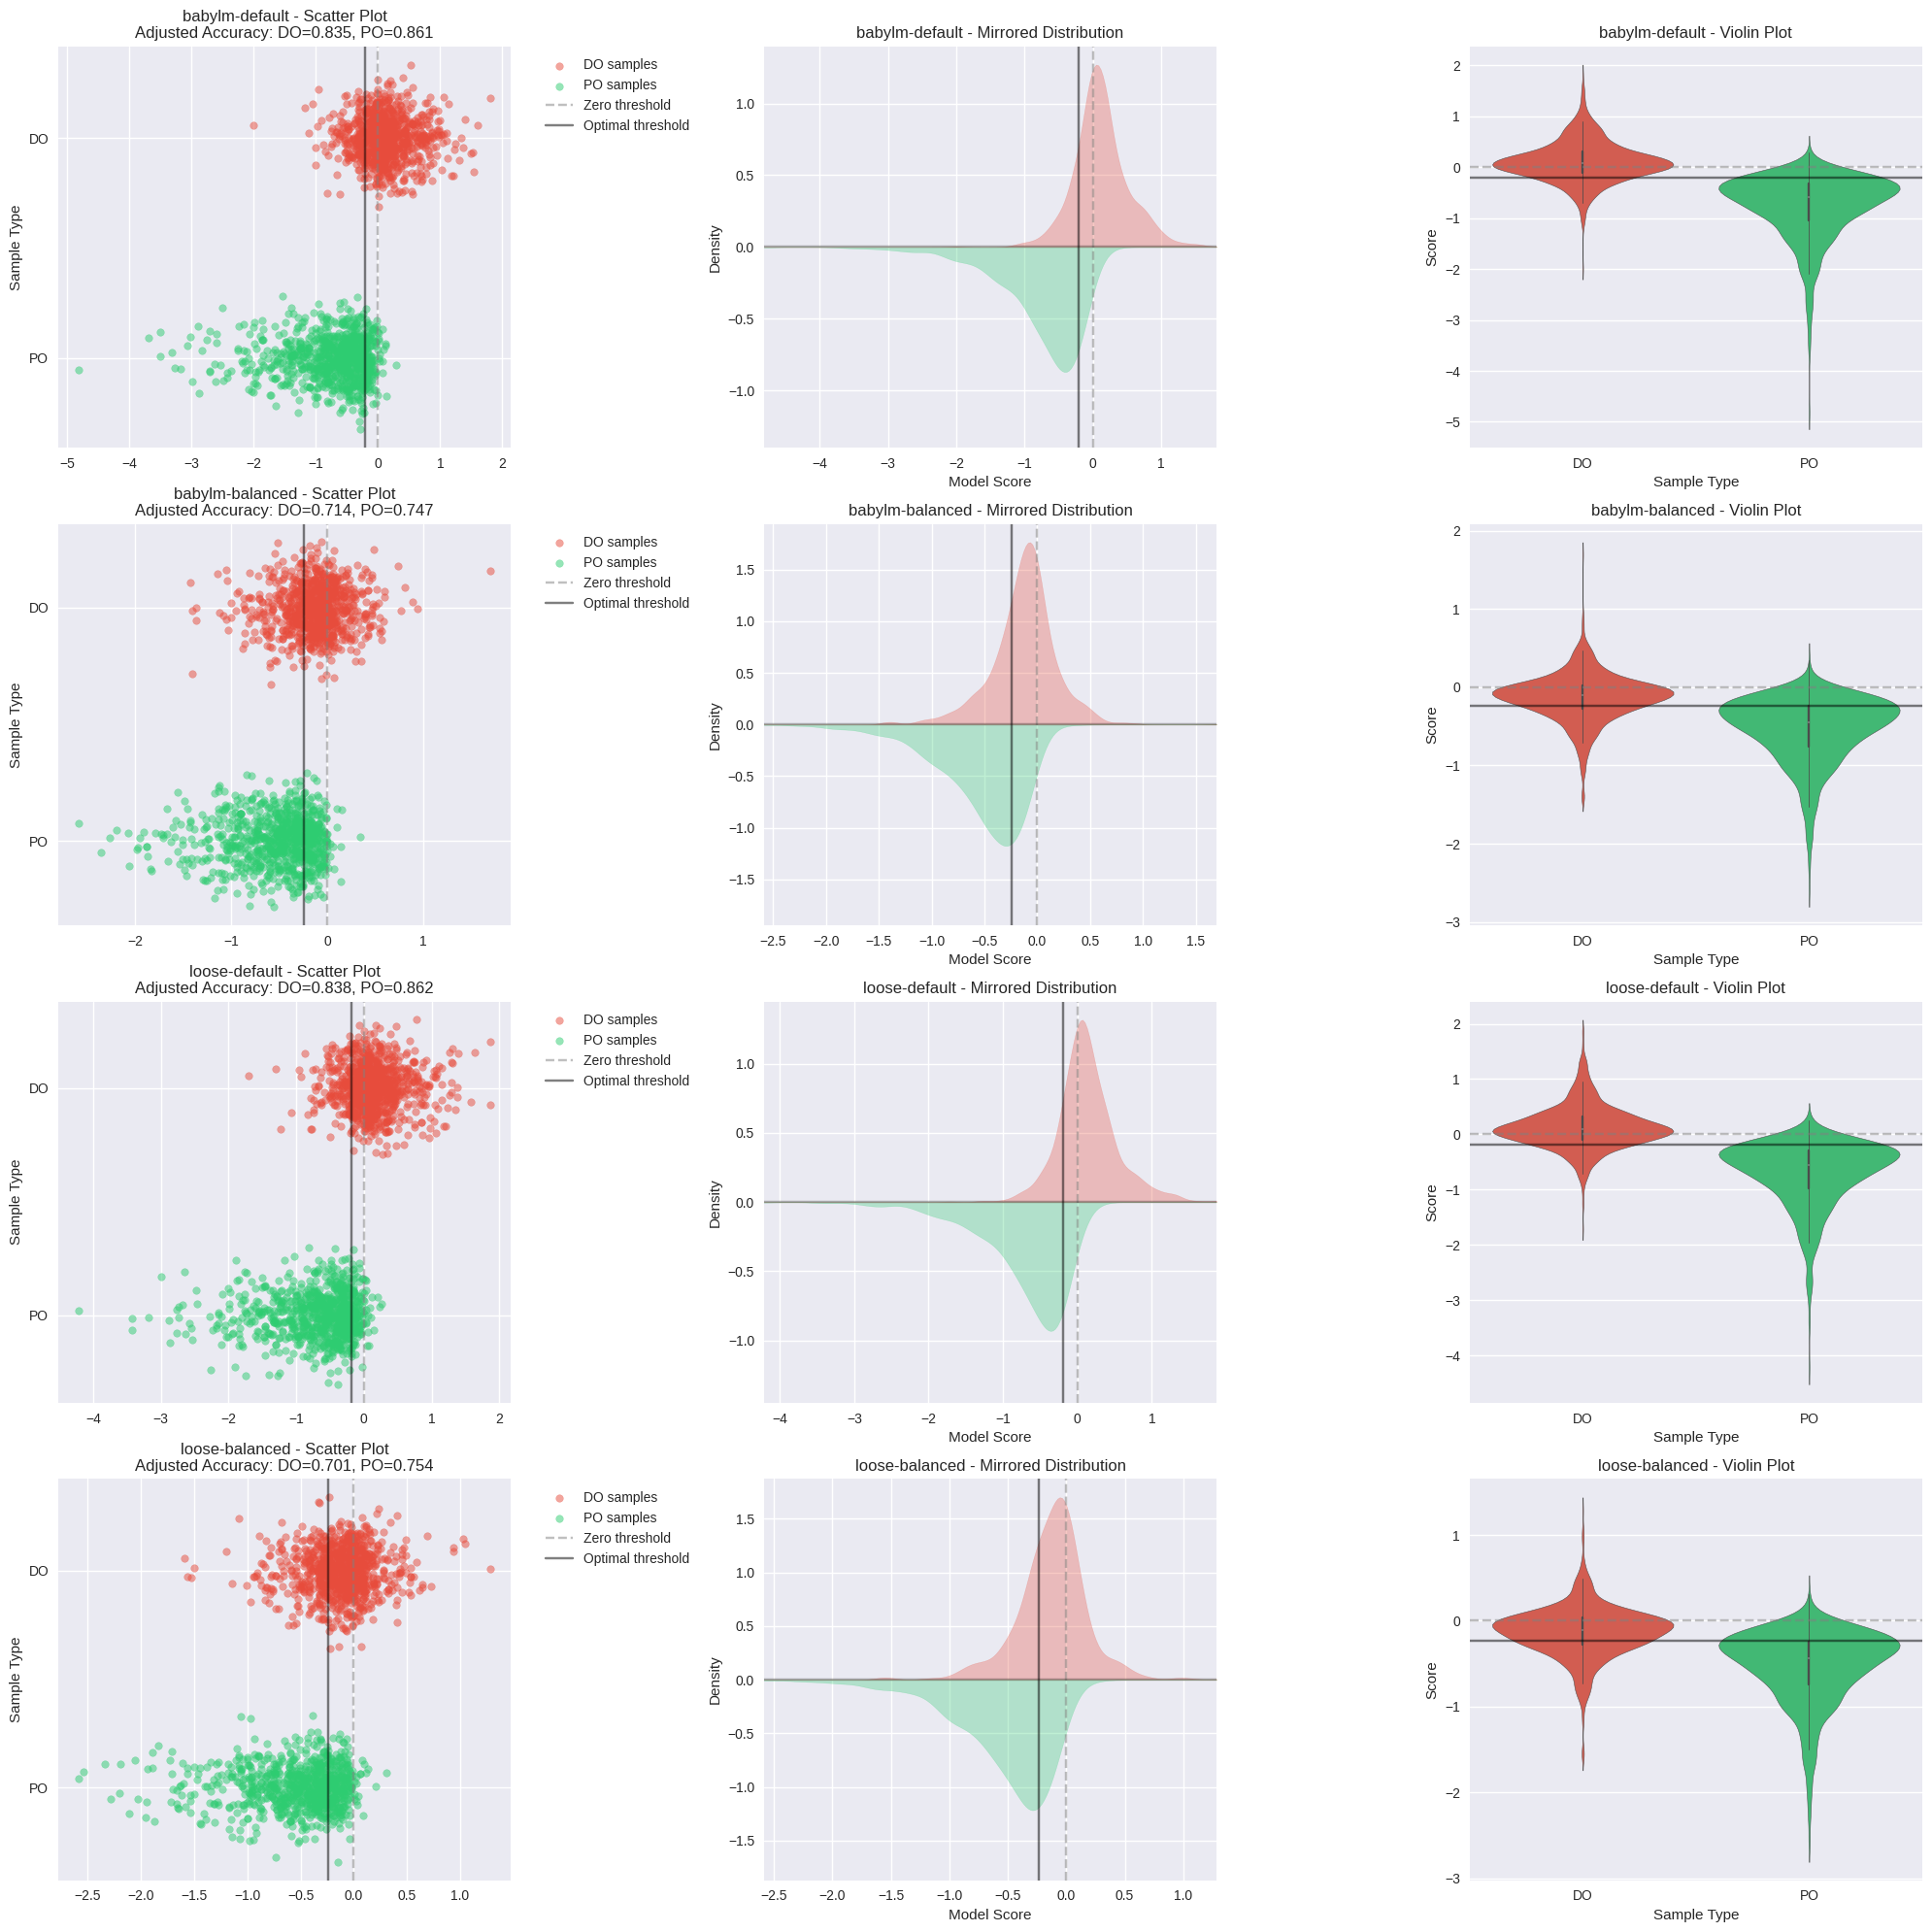

In [23]:
#distribution plots on actual datives
import pandas as pd
import os 

os.chdir('/home/qy2672/backup')
pos = pd.read_csv('experiments/po_datives.csv')
dos = pd.read_csv('experiments/do_datives.csv')

models = ['babylm-default', 'babylm-balanced', 'loose-default', 'loose-balanced']

import numpy as np

def calculate_accuracies(scores, shift, target_class):
    """Calculate accuracy for a given shift. target_class indicates if these are DO samples (1) or PO samples (0)"""
    predictions = (scores + shift) > 0  # Predict DO if score > 0
    accuracy = np.mean(predictions == target_class)
    return accuracy

results = {}
results['babylm-default'] = {'shift': 0.2129}
results['babylm-balanced'] = {'shift': 0.2399}
results['loose-default'] = {'shift': 0.1876}
results['loose-balanced'] = {'shift': 0.2361}

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

fig, axes = plt.subplots(4, 3, figsize=(20, 20))  # Updated layout for violin plots
plt.style.use('seaborn-v0_8')

# Color scheme
po_color = '#2ecc71'  # green
do_color = '#e74c3c'  # red

for idx, model_name in enumerate(models):
    ax_scatter = axes[idx, 0]
    ax_combined = axes[idx, 1]
    ax_violin = axes[idx, 2]  

    do_scores = dos[model_name + '_ratio']
    po_scores = pos[model_name + '_ratio']
    shift = results[model_name]['shift']

    results[model_name]['dos_accuracy'] = calculate_accuracies(do_scores, shift, target_class=1)
    results[model_name]['pos_accuracy'] = calculate_accuracies(po_scores, shift, target_class=0)
    results[model_name]['overall_accuracy'] = (results[model_name]['dos_accuracy'] * len(do_scores) +
                                               results[model_name]['pos_accuracy'] * len(po_scores)) / \
                                              (len(do_scores) + len(po_scores))

    # 1. Scatter plot with jitter
    do_y = np.random.normal(0.6, 0.02, size=len(do_scores))  
    po_y = np.random.normal(0.4, 0.02, size=len(po_scores))
    ax_scatter.scatter(do_scores, do_y, alpha=0.5, c=do_color, label='DO samples', s=30)
    ax_scatter.scatter(po_scores, po_y, alpha=0.5, c=po_color, label='PO samples', s=30)
    ax_scatter.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='Zero threshold')
    ax_scatter.axvline(x=-shift, color='black', linestyle='-', alpha=0.5, label='Optimal threshold')
    ax_scatter.set_title(f'{model_name} - Scatter Plot\nAdjusted Accuracy: DO={results[model_name]["dos_accuracy"]:.3f}, PO={results[model_name]["pos_accuracy"]:.3f}')
    ax_scatter.set_ylabel('Sample Type')
    ax_scatter.set_yticks([0.4, 0.6])
    ax_scatter.set_yticklabels(['PO', 'DO'])
    ax_scatter.legend(bbox_to_anchor=(1.05, 1))

    # 2. Mirrored density plots (second column)
    kde_do = stats.gaussian_kde(do_scores)
    kde_po = stats.gaussian_kde(po_scores)
    x_range = np.linspace(min(np.min(do_scores), np.min(po_scores)),
                          max(np.max(do_scores), np.max(po_scores)), 200)
    do_density = kde_do(x_range)
    po_density = kde_po(x_range)

    ax_combined.fill_between(x_range, do_density, np.zeros_like(x_range), alpha=0.3, color=do_color, label='DO samples')
    ax_combined.fill_between(x_range, -po_density, np.zeros_like(x_range), alpha=0.3, color=po_color, label='PO samples')
    ax_combined.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='Zero threshold')
    ax_combined.axvline(x=-shift, color='black', linestyle='-', alpha=0.5, label='Optimal threshold')
    ax_combined.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax_combined.set_title(f'{model_name} - Mirrored Distribution')
    ax_combined.set_xlabel('Model Score')
    ax_combined.set_ylabel('Density')
    ax_combined.set_xlim(x_range[0], x_range[-1])

    max_density = max(np.max(do_density), np.max(po_density))
    ax_combined.set_ylim(-max_density * 1.1, max_density * 1.1)

    # 3. Violin plot (third column)
    data = {
        'Score': np.concatenate([do_scores, po_scores]),
        'Sample Type': ['DO'] * len(do_scores) + ['PO'] * len(po_scores)
    }
    sns.violinplot(data=data, x='Sample Type', y='Score', palette={'DO': do_color, 'PO': po_color}, ax=ax_violin)
    ax_violin.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Zero threshold')
    ax_violin.axhline(y=-shift, color='black', linestyle='-', alpha=0.5, label='Optimal threshold')
    ax_violin.set_title(f'{model_name} - Violin Plot')

plt.tight_layout()
plt.show()

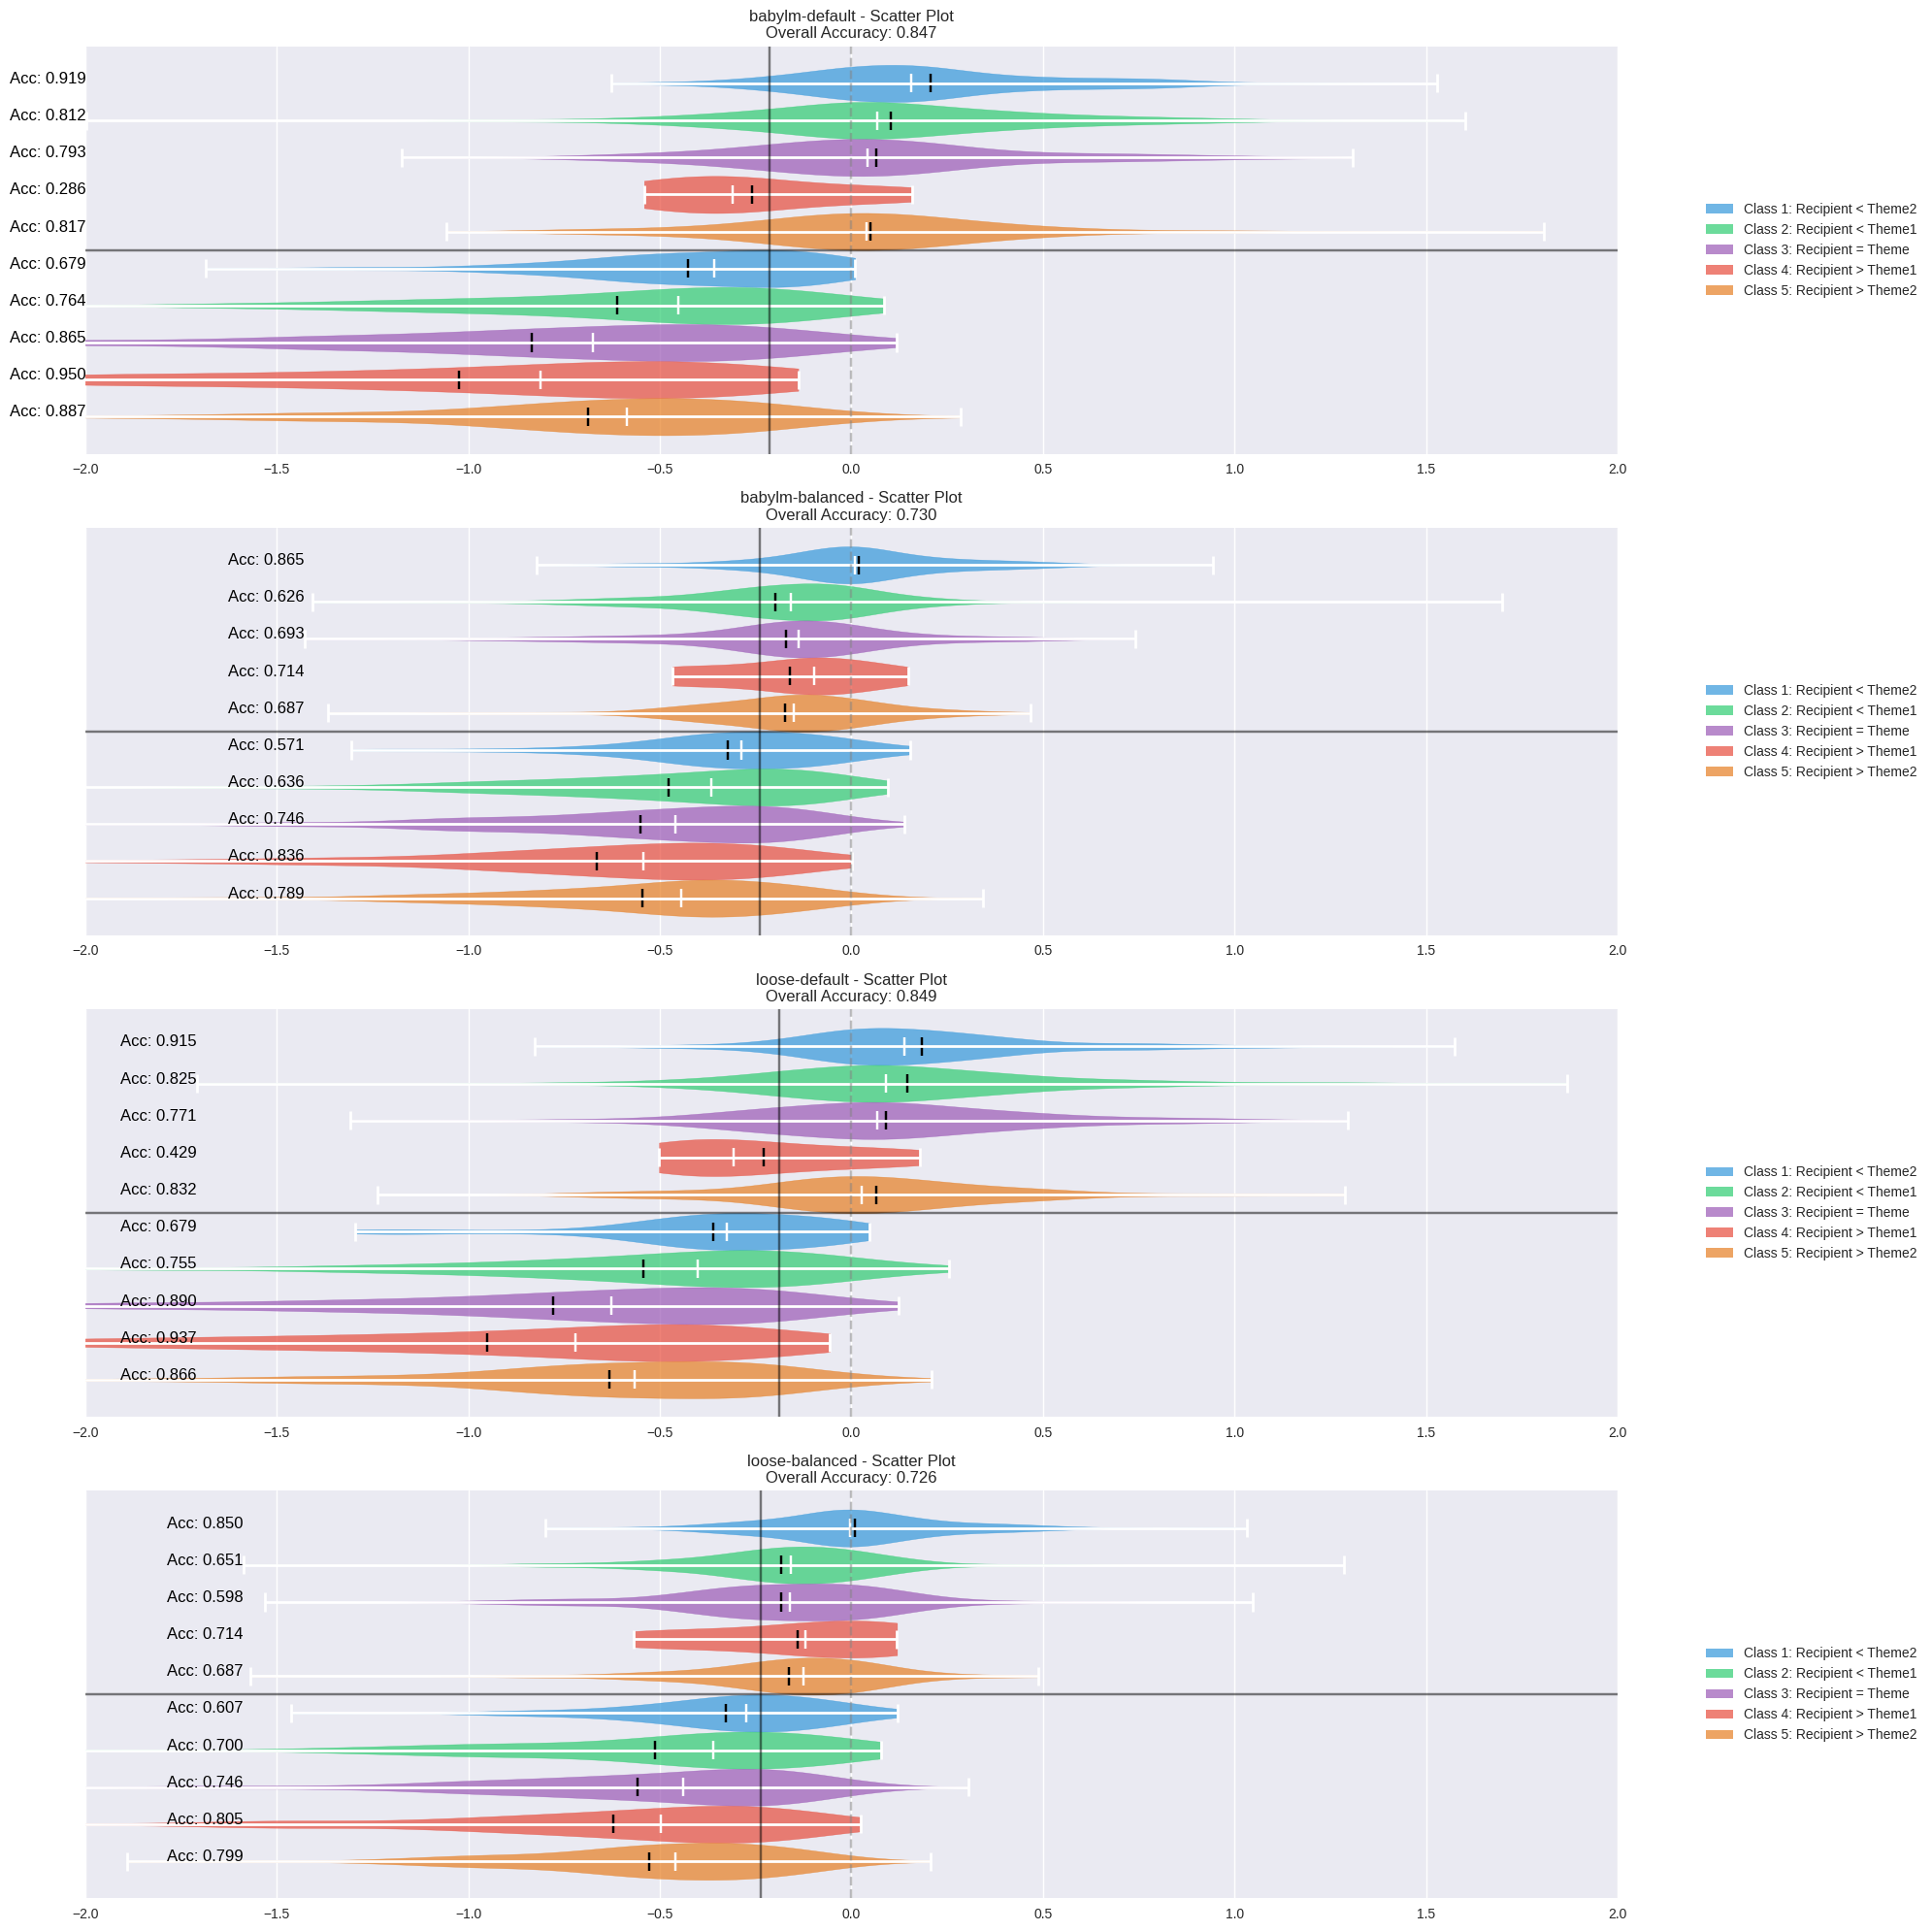


PMI Table for babylm-default:

                             actual = do  actual = po  predicted = do  predicted = po
Class 1: Recipient < Theme2     0.646043    -1.420040        0.687360       -1.406507
Class 2: Recipient < Theme1     0.543728    -1.021837        0.423346       -0.617025
Class 3: Recipient = Theme     -0.571722     0.446539       -0.458318        0.353565
Class 4: Recipient > Theme1    -3.640229     1.014230       -3.067595        0.924993
Class 5: Recipient > Theme2    -0.383417     0.332003       -0.347552        0.285044

PMI Table for babylm-balanced:

                             actual = do  actual = po  predicted = do  predicted = po
Class 1: Recipient < Theme2     0.646043    -1.420040        0.669219       -1.250573
Class 2: Recipient < Theme1     0.543728    -1.021837        0.188697       -0.212984
Class 3: Recipient = Theme     -0.571722     0.446539       -0.276509        0.228127
Class 4: Recipient > Theme1    -3.640229     1.014230       -1.407846      

In [13]:
#cluster when sorted by length: actual datives subset
import pandas as pd
import os 

os.chdir('/home/qy2672/backup')
models = ['babylm-default', 'babylm-balanced', 'loose-default', 'loose-balanced']

import numpy as np

def calculate_accuracies(scores, shift, target_class):
    """Calculate accuracy for a given shift. target_class indicates if these are DO samples (1) or PO samples (0)"""
    predictions = (scores + shift) > 0  # Predict DO if score > 0
    accuracy = np.mean(predictions == target_class)
    return accuracy

results = {}
results['babylm-default'] = {'shift': 0.2129}
results['babylm-balanced'] = {'shift': 0.2399}
results['loose-default'] = {'shift': 0.1876}
results['loose-balanced'] = {'shift': 0.2361}


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

dos = pd.read_csv('experiments/do_datives.csv')
pos = pd.read_csv('experiments/po_datives.csv')
# Add a class column to the test_set based on the comparisons of recipient and theme lengths
def classify_row(row):
    recipient_len = len(str(row['recipient']).split())
    theme_len = len(str(row['theme']).split())
    if recipient_len < theme_len -2:
        return 'Class 1: Recipient < Theme2'
    elif recipient_len == theme_len - 1:
        return 'Class 2: Recipient < Theme1'
    elif recipient_len == theme_len:
        return 'Class 3: Recipient = Theme'
    elif recipient_len == theme_len + 1:
        return 'Class 4: Recipient > Theme1'
    else:
        return 'Class 5: Recipient > Theme2'

dos['class'] = dos.apply(classify_row, axis=1)
pos['class'] = pos.apply(classify_row, axis=1)

# Colors for the three classes
class_colors = {
    'Class 1: Recipient < Theme2': '#3498db',  # blue
    'Class 2: Recipient < Theme1': '#2ecc71',  # green
    'Class 3: Recipient = Theme': '#9b59b6',  # purple
    'Class 4: Recipient > Theme1': '#e74c3c',  # red
    'Class 5: Recipient > Theme2': '#e67e22'   # orange
}

fig, axes = plt.subplots(4, 1, figsize=(20, 20))  # Layout remains the same
plt.style.use('seaborn-v0_8')

for idx, model_name in enumerate(models):
    ax_scatter = axes[idx]

    do_scores = dos[model_name + '_ratio']
    po_scores = pos[model_name + '_ratio']
    shift = results[model_name]['shift']

    results[model_name]['dos_accuracy'] = calculate_accuracies(do_scores, shift, target_class=1)
    results[model_name]['pos_accuracy'] = calculate_accuracies(po_scores, shift, target_class=0)
    results[model_name]['overall_accuracy'] = (results[model_name]['dos_accuracy'] * len(do_scores) +
                                               results[model_name]['pos_accuracy'] * len(po_scores)) / \
                                              (len(do_scores) + len(po_scores))

    # 1. Scatter Plot with Class-Specific Accuracies
    class_accuracies = {}
    legend_elements = []
    for cls in class_colors:
        cls_scores = dos[(dos['class'] == cls)][model_name + '_ratio']
        target_class = 1
        class_accuracies[(cls, 'do')] = calculate_accuracies(cls_scores, shift, target_class)
        
        # Plot scatter points
        cls_y = {
            'Class 1: Recipient < Theme2': 0.4,
            'Class 2: Recipient < Theme1': 0.3,
            'Class 3: Recipient = Theme': 0.2,
            'Class 4: Recipient > Theme1': 0.1,
            'Class 5: Recipient > Theme2': 0
        }[cls] + 0.5 
        # Create violin plot with increased width and added mean/median indicators
        vp = ax_scatter.violinplot(cls_scores, positions=[cls_y],
                             vert=False,  
                             widths=0.10,  
                             showmeans=True,  # Show mean as a point
                             showmedians=True)  # Show median as a line
        
        for pc in vp['bodies']:
            pc.set_facecolor(class_colors[cls])
            pc.set_alpha(0.7)
            pc.set_edgecolor(class_colors[cls])  
        
        
        vp['cmeans'].set_colors('black')  # Mean point in black
        vp['cmedians'].set_colors('white')  # Median line in white
        
        
        for partname in ('cbars', 'cmins', 'cmaxes'):
            vp[partname].set_edgecolor('white')
            vp[partname].set_linewidth(2)  
        legend_elements.append(plt.Rectangle((0,0), 1, 1, fc=class_colors[cls], 
                                      label=cls, alpha=0.7))

        # Add accuracy label next to the cluster
        accuracy_label = f"Acc: {class_accuracies[(cls, 'do')]:.3f}"
        x_offset = dos[model_name + '_ratio'].min()
        ax_scatter.text(x_offset, cls_y, accuracy_label, fontsize=12, ha='right', color='black')
    
    for cls in class_colors:
        cls_scores = pos[(pos['class'] == cls)][model_name + '_ratio']
        target_class = 0
        class_accuracies[(cls, 'po')] = calculate_accuracies(cls_scores, shift, target_class)
        
        # Plot scatter points
        cls_y = {
            'Class 1: Recipient < Theme2': 0.4,
            'Class 2: Recipient < Theme1': 0.3,
            'Class 3: Recipient = Theme': 0.2,
            'Class 4: Recipient > Theme1': 0.1,
            'Class 5: Recipient > Theme2': 0
        }[cls] 
        vp = ax_scatter.violinplot(cls_scores, positions=[cls_y],
                             vert=False,  
                             widths=0.10,  
                             showmeans=True,  # Show mean as a point
                             showmedians=True)  # Show median as a line
        
        for pc in vp['bodies']:
            pc.set_facecolor(class_colors[cls])
            pc.set_alpha(0.7)
            pc.set_edgecolor(class_colors[cls])  
        
        
        vp['cmeans'].set_colors('black')  # Mean point in black
        vp['cmedians'].set_colors('white')  # Median line in white
        
        
        for partname in ('cbars', 'cmins', 'cmaxes'):
            vp[partname].set_edgecolor('white')
            vp[partname].set_linewidth(2)  

        # Add accuracy label next to the cluster
        accuracy_label = f"Acc: {class_accuracies[(cls, 'po')]:.3f}"
        x_offset = dos[model_name + '_ratio'].min() 
        ax_scatter.text(x_offset, cls_y, accuracy_label, fontsize=12, ha='right', color='black')


    ax_scatter.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='Zero threshold')
    ax_scatter.axvline(x=-shift, color='black', linestyle='-', alpha=0.5, label='Optimal threshold')
    ax_scatter.axhline(y=0.45, color='black', linestyle='-', alpha=0.5)
    ax_scatter.set_title(f'{model_name} - Scatter Plot\nOverall Accuracy: {results[model_name]["overall_accuracy"]:.3f}')
    ax_scatter.set_xlim(-2, 2)
    ax_scatter.set_yticks([])

    ax_scatter.legend(handles=legend_elements, loc='center left', 
                 bbox_to_anchor=(1.05, 0.5))

plt.tight_layout()
plt.show()

from math import log
def compute_and_format_pmi(data, label_col, class_col, class_labels, model_name=None):
    total_samples = len(data)
    pmi_table = {cls: {'actual = do': 0, 'actual = po': 0, 'predicted = do': 0, 'predicted = po': 0} for cls in class_labels}

    # Compute PMI for actual and predicted labels
    for cls in class_labels:
        # Filter data by class
        class_data = data[data[class_col] == cls]
        class_count = len(class_data)

        for label, label_desc in [(1, 'actual = do'), (0, 'actual = po')]:  # Actual labels
            joint_count = len(class_data[class_data[label_col] == label])
            p_xy = joint_count / total_samples
            p_x = len(data[data[label_col] == label]) / total_samples
            p_y = class_count / total_samples
            pmi_table[cls][label_desc] = log(p_xy / (p_x * p_y), 2) if p_xy > 0 else float('-inf')

        if model_name:
            for pred_label, pred_desc in [(1, 'predicted = do'), (0, 'predicted = po')]:  # Predicted labels
                joint_count = len(class_data[class_data[f'{model_name}_predicted_label'] == pred_label])
                p_xy = joint_count / total_samples
                p_x = len(data[data[f'{model_name}_predicted_label'] == pred_label]) / total_samples
                p_y = class_count / total_samples
                pmi_table[cls][pred_desc] = log(p_xy / (p_x * p_y), 2) if p_xy > 0 else float('-inf')

    # Convert PMI table to a DataFrame
    formatted_table = pd.DataFrame(pmi_table).T
    return formatted_table

# Combine DO and PO datasets
dos['actual_label'] = 1  # DO samples are labeled as 1
pos['actual_label'] = 0  # PO samples are labeled as 0
combined = pd.concat([dos, pos])

# Add predicted labels for all models
for model_name in models:
    combined[f'{model_name}_predicted_label'] = (combined[model_name + '_ratio'] + results[model_name]['shift']) > 0

# Compute and display formatted tables for each model
class_labels = class_colors.keys()
formatted_tables = {}
pd.set_option('display.width', 1000) 
pd.set_option('display.max_columns', None)
for model_name in models:
    formatted_table = compute_and_format_pmi(combined, 'actual_label', 'class', class_labels, model_name=model_name)
    formatted_tables[model_name] = formatted_table
    print(f"\nPMI Table for {model_name}:\n")
    print(formatted_table)

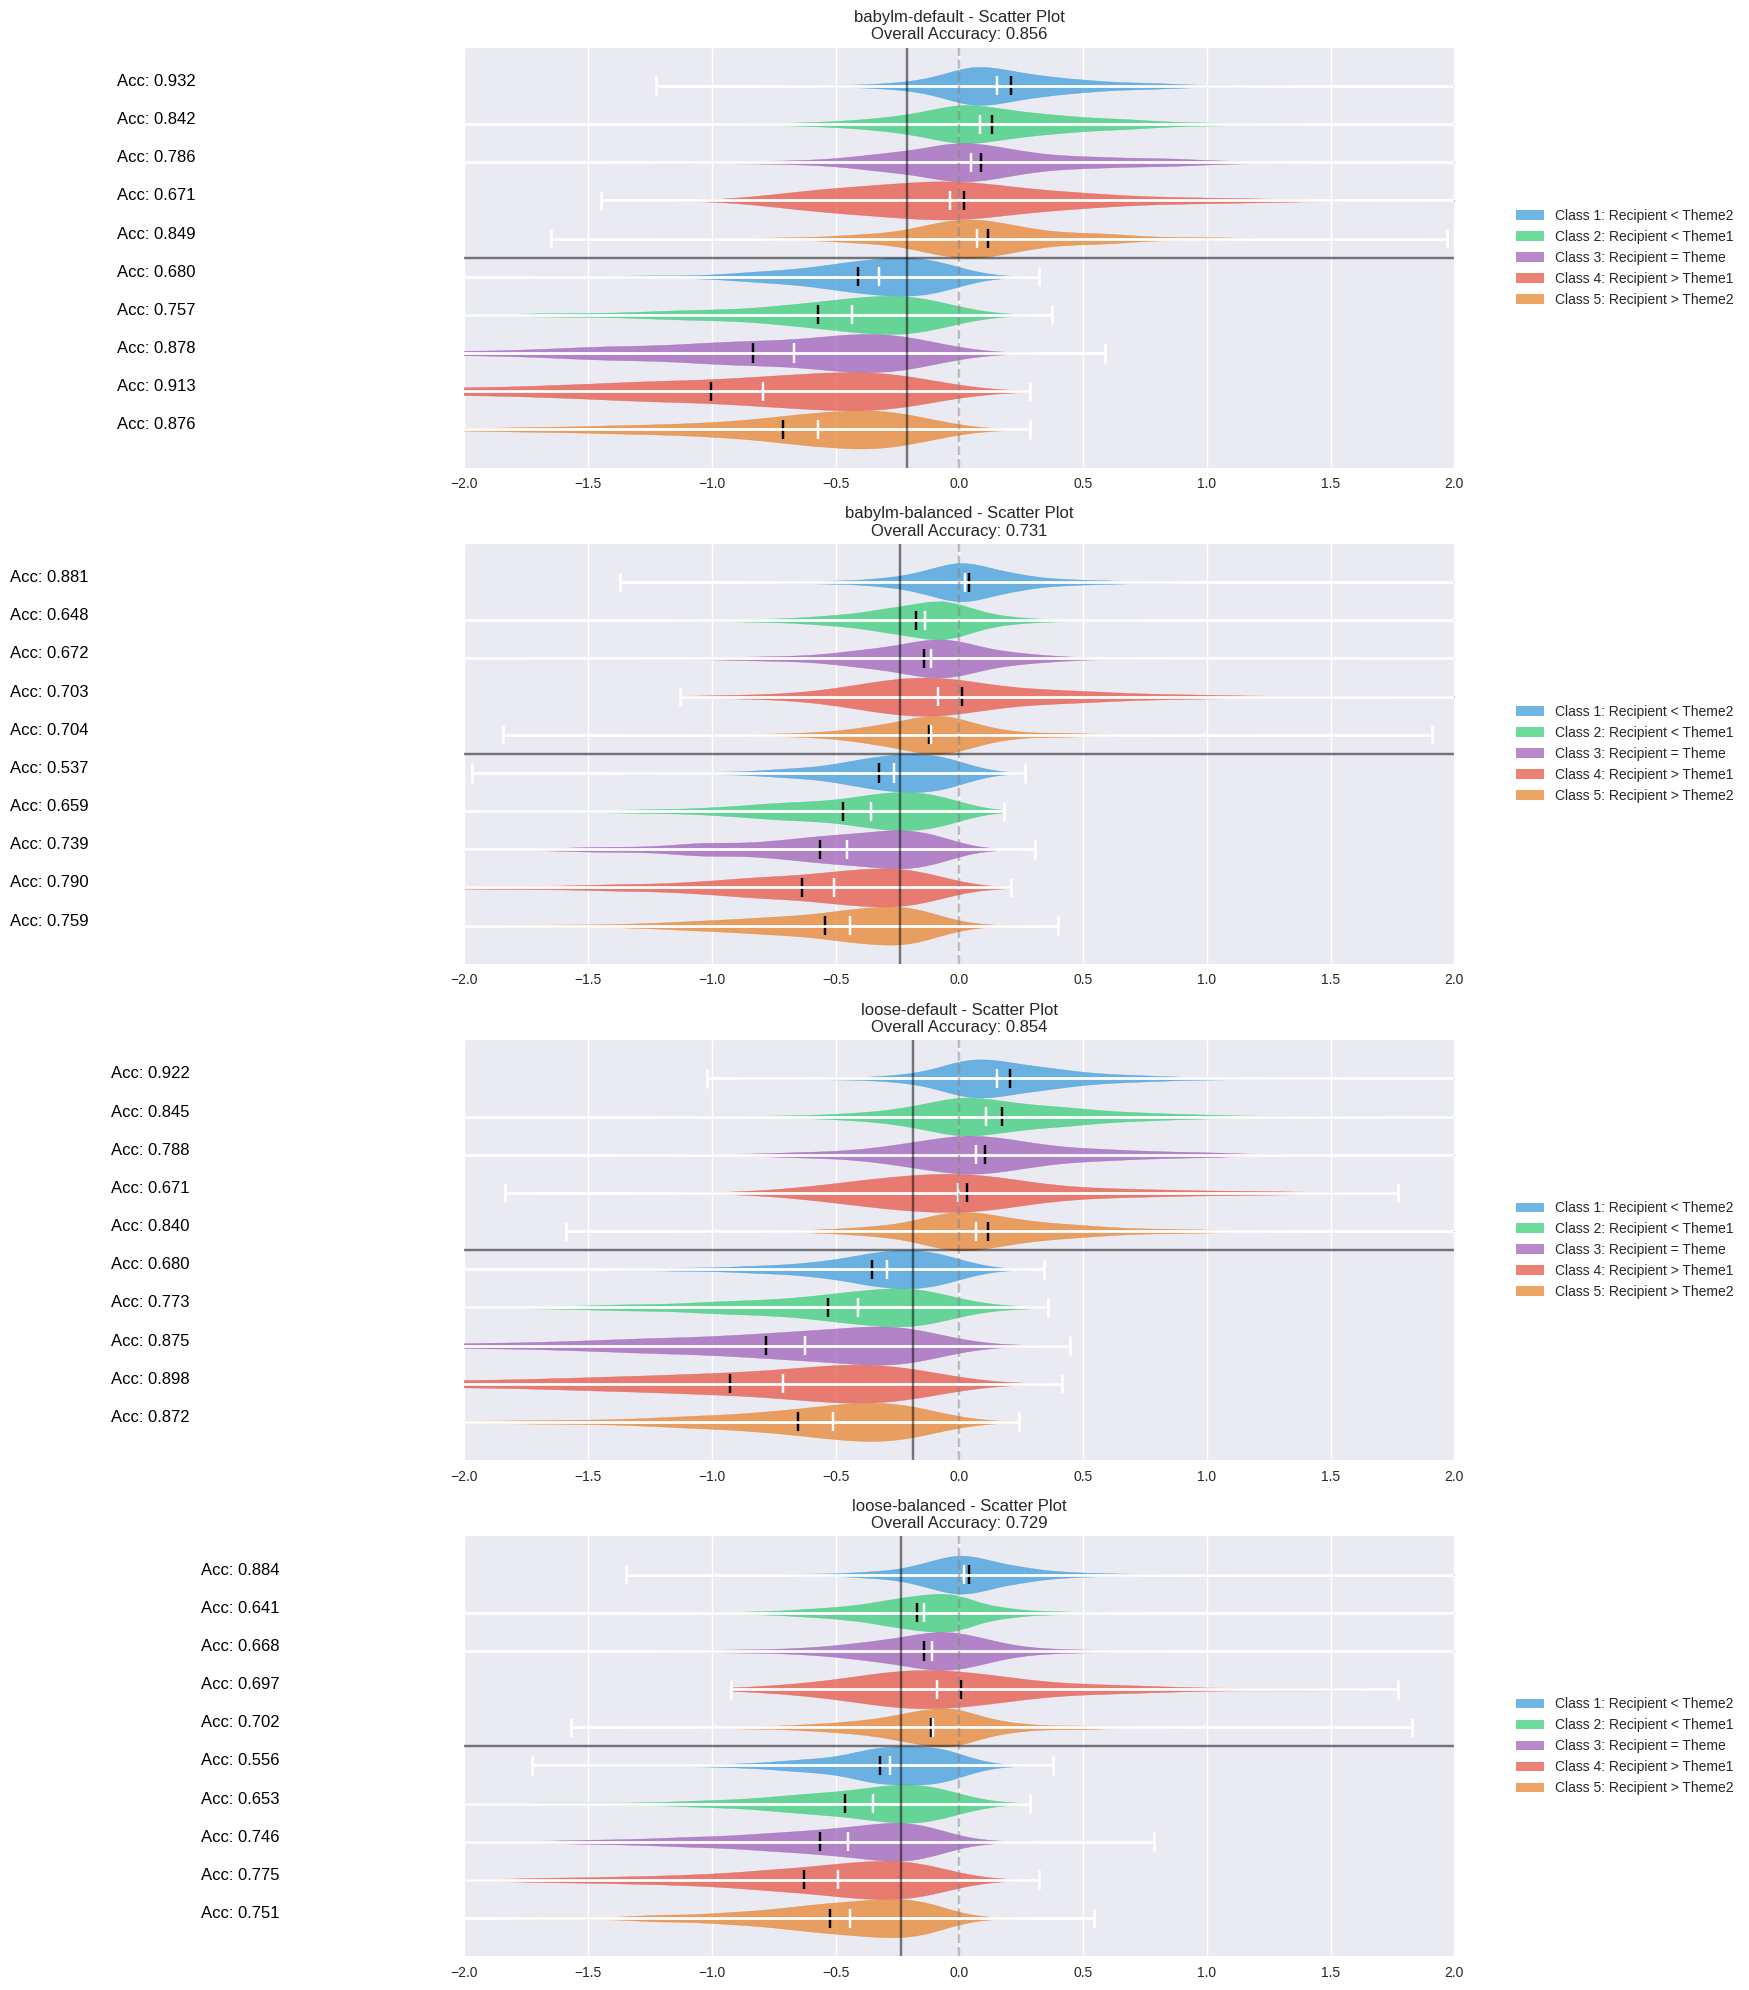


PMI Table for babylm-default:

                             actual = do  actual = po  predicted = do  predicted = po
Class 1: Recipient < Theme2     0.494635    -1.773595        0.542144       -1.603631
Class 2: Recipient < Theme1     0.379643    -1.061224        0.307053       -0.618999
Class 3: Recipient = Theme     -0.346678     0.453699       -0.394404        0.434931
Class 4: Recipient > Theme1    -2.523137     1.280403       -1.974354        1.068064
Class 5: Recipient > Theme2    -0.420541     0.523510       -0.350486        0.397535

PMI Table for babylm-balanced:

                             actual = do  actual = po  predicted = do  predicted = po
Class 1: Recipient < Theme2     0.494635    -1.773595        0.573289       -1.417989
Class 2: Recipient < Theme1     0.379643    -1.061224        0.080828       -0.110770
Class 3: Recipient = Theme     -0.346678     0.453699       -0.271967        0.287300
Class 4: Recipient > Theme1    -2.523137     1.280403       -1.086586      

In [14]:
#cluster when sorted by length: entire test set (possibly not actually datives) 
import pandas as pd
import os 

os.chdir('/home/qy2672/backup')
models = ['babylm-default', 'babylm-balanced', 'loose-default', 'loose-balanced']

import numpy as np

def calculate_accuracies(scores, shift, target_class):
    """Calculate accuracy for a given shift. target_class indicates if these are DO samples (1) or PO samples (0)"""
    predictions = (scores + shift) > 0  # Predict DO if score > 0
    accuracy = np.mean(predictions == target_class)
    return accuracy

results = {}
results['babylm-default'] = {'shift': 0.2129}
results['babylm-balanced'] = {'shift': 0.2399}
results['loose-default'] = {'shift': 0.1876}
results['loose-balanced'] = {'shift': 0.2361}


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

dos = pd.read_csv('data/datives/test/alternant_of_dos.csv')
pos = pd.read_csv('data/datives/test/alternant_of_pos.csv')

# Add a class column to the test_set based on the comparisons of recipient and theme lengths
def classify_row(row):
    recipient_len = len(str(row['recipient']).split())
    theme_len = len(str(row['theme']).split())
    if recipient_len < theme_len -2:
        return 'Class 1: Recipient < Theme2'
    elif recipient_len == theme_len - 1:
        return 'Class 2: Recipient < Theme1'
    elif recipient_len == theme_len:
        return 'Class 3: Recipient = Theme'
    elif recipient_len == theme_len + 1:
        return 'Class 4: Recipient > Theme1'
    else:
        return 'Class 5: Recipient > Theme2'

dos['class'] = dos.apply(classify_row, axis=1)
pos['class'] = pos.apply(classify_row, axis=1)

# Colors for the three classes
class_colors = {
    'Class 1: Recipient < Theme2': '#3498db',  # blue
    'Class 2: Recipient < Theme1': '#2ecc71',  # green
    'Class 3: Recipient = Theme': '#9b59b6',  # purple
    'Class 4: Recipient > Theme1': '#e74c3c',  # red
    'Class 5: Recipient > Theme2': '#e67e22'   # orange
}

fig, axes = plt.subplots(4, 1, figsize=(20, 20))  # Layout remains the same
plt.style.use('seaborn-v0_8')

for idx, model_name in enumerate(models):
    ax_scatter = axes[idx]

    do_scores = dos[model_name + '_ratio']
    po_scores = pos[model_name + '_ratio']
    shift = results[model_name]['shift']

    results[model_name]['dos_accuracy'] = calculate_accuracies(do_scores, shift, target_class=1)
    results[model_name]['pos_accuracy'] = calculate_accuracies(po_scores, shift, target_class=0)
    results[model_name]['overall_accuracy'] = (results[model_name]['dos_accuracy'] * len(do_scores) +
                                               results[model_name]['pos_accuracy'] * len(po_scores)) / \
                                              (len(do_scores) + len(po_scores))

    # 1. Scatter Plot with Class-Specific Accuracies
    class_accuracies = {}
    legend_elements = []
    for cls in class_colors:
        cls_scores = dos[(dos['class'] == cls)][model_name + '_ratio']
        target_class = 1
        class_accuracies[(cls, 'do')] = calculate_accuracies(cls_scores, shift, target_class)
        
        # Plot scatter points
        cls_y = {
            'Class 1: Recipient < Theme2': 0.4,
            'Class 2: Recipient < Theme1': 0.3,
            'Class 3: Recipient = Theme': 0.2,
            'Class 4: Recipient > Theme1': 0.1,
            'Class 5: Recipient > Theme2': 0
        }[cls] + 0.5 
        # Create violin plot with increased width and added mean/median indicators
        vp = ax_scatter.violinplot(cls_scores, positions=[cls_y],
                             vert=False,  
                             widths=0.10,  
                             showmeans=True,  # Show mean as a point
                             showmedians=True)  # Show median as a line
        
        for pc in vp['bodies']:
            pc.set_facecolor(class_colors[cls])
            pc.set_alpha(0.7)
            pc.set_edgecolor(class_colors[cls])  
        
        
        vp['cmeans'].set_colors('black')  # Mean point in black
        vp['cmedians'].set_colors('white')  # Median line in white
        
        
        for partname in ('cbars', 'cmins', 'cmaxes'):
            vp[partname].set_edgecolor('white')
            vp[partname].set_linewidth(2)  
        legend_elements.append(plt.Rectangle((0,0), 1, 1, fc=class_colors[cls], 
                                      label=cls, alpha=0.7))

        # Add accuracy label next to the cluster
        accuracy_label = f"Acc: {class_accuracies[(cls, 'do')]:.3f}"
        x_offset = dos[model_name + '_ratio'].min()
        ax_scatter.text(x_offset, cls_y, accuracy_label, fontsize=12, ha='right', color='black')
    
    for cls in class_colors:
        cls_scores = pos[(pos['class'] == cls)][model_name + '_ratio']
        target_class = 0
        class_accuracies[(cls, 'po')] = calculate_accuracies(cls_scores, shift, target_class)
        
        # Plot scatter points
        cls_y = {
            'Class 1: Recipient < Theme2': 0.4,
            'Class 2: Recipient < Theme1': 0.3,
            'Class 3: Recipient = Theme': 0.2,
            'Class 4: Recipient > Theme1': 0.1,
            'Class 5: Recipient > Theme2': 0
        }[cls] 
        vp = ax_scatter.violinplot(cls_scores, positions=[cls_y],
                             vert=False,  
                             widths=0.10,  
                             showmeans=True,  # Show mean as a point
                             showmedians=True)  # Show median as a line
        
        for pc in vp['bodies']:
            pc.set_facecolor(class_colors[cls])
            pc.set_alpha(0.7)
            pc.set_edgecolor(class_colors[cls])  
        
        
        vp['cmeans'].set_colors('black')  # Mean point in black
        vp['cmedians'].set_colors('white')  # Median line in white
        
        
        for partname in ('cbars', 'cmins', 'cmaxes'):
            vp[partname].set_edgecolor('white')
            vp[partname].set_linewidth(2)  

        # Add accuracy label next to the cluster
        accuracy_label = f"Acc: {class_accuracies[(cls, 'po')]:.3f}"
        x_offset = dos[model_name + '_ratio'].min() 
        ax_scatter.text(x_offset, cls_y, accuracy_label, fontsize=12, ha='right', color='black')


    ax_scatter.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='Zero threshold')
    ax_scatter.axvline(x=-shift, color='black', linestyle='-', alpha=0.5, label='Optimal threshold')
    ax_scatter.axhline(y=0.45, color='black', linestyle='-', alpha=0.5)
    ax_scatter.set_title(f'{model_name} - Scatter Plot\nOverall Accuracy: {results[model_name]["overall_accuracy"]:.3f}')
    ax_scatter.set_xlim(-2, 2)
    ax_scatter.set_yticks([])

    ax_scatter.legend(handles=legend_elements, loc='center left', 
                 bbox_to_anchor=(1.05, 0.5))

plt.tight_layout()
plt.show()

from math import log
def compute_and_format_pmi(data, label_col, class_col, class_labels, model_name=None):
    total_samples = len(data)
    pmi_table = {cls: {'actual = do': 0, 'actual = po': 0, 'predicted = do': 0, 'predicted = po': 0} for cls in class_labels}

    # Compute PMI for actual and predicted labels
    for cls in class_labels:
        # Filter data by class
        class_data = data[data[class_col] == cls]
        class_count = len(class_data)

        for label, label_desc in [(1, 'actual = do'), (0, 'actual = po')]:  # Actual labels
            joint_count = len(class_data[class_data[label_col] == label])
            p_xy = joint_count / total_samples
            p_x = len(data[data[label_col] == label]) / total_samples
            p_y = class_count / total_samples
            pmi_table[cls][label_desc] = log(p_xy / (p_x * p_y), 2) if p_xy > 0 else float('-inf')

        if model_name:
            for pred_label, pred_desc in [(1, 'predicted = do'), (0, 'predicted = po')]:  # Predicted labels
                joint_count = len(class_data[class_data[f'{model_name}_predicted_label'] == pred_label])
                p_xy = joint_count / total_samples
                p_x = len(data[data[f'{model_name}_predicted_label'] == pred_label]) / total_samples
                p_y = class_count / total_samples
                pmi_table[cls][pred_desc] = log(p_xy / (p_x * p_y), 2) if p_xy > 0 else float('-inf')

    # Convert PMI table to a DataFrame
    formatted_table = pd.DataFrame(pmi_table).T
    return formatted_table

# Combine DO and PO datasets
dos['actual_label'] = 1  # DO samples are labeled as 1
pos['actual_label'] = 0  # PO samples are labeled as 0
combined = pd.concat([dos, pos])

# Add predicted labels for all models
for model_name in models:
    combined[f'{model_name}_predicted_label'] = (combined[model_name + '_ratio'] + results[model_name]['shift']) > 0

# Compute and display formatted tables for each model
class_labels = class_colors.keys()
formatted_tables = {}
pd.set_option('display.width', 1000) 
pd.set_option('display.max_columns', None)
for model_name in models:
    formatted_table = compute_and_format_pmi(combined, 'actual_label', 'class', class_labels, model_name=model_name)
    formatted_tables[model_name] = formatted_table
    print(f"\nPMI Table for {model_name}:\n")
    print(formatted_table)
